In [1]:
from pyIHACRES import ihacres_funcs
from pyIHACRES.Network import load_network
from pyIHACRES.Network import StreamNode, DamNode
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
net = load_network("../pyIHACRES/config/network.yml", first_node=406214)

In [3]:
net.network

{406000: <pyIHACRES.Network.DamNode.DamNode at 0xfe31668>,
 406201: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe31588>,
 406202: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe31710>,
 406214: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe315f8>,
 406218: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe315c0>,
 406219: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe31908>,
 406224: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe317b8>,
 406265: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe31860>}

In [4]:
network = net.network

In [5]:
# top_level_nodes = {k: node for k, node in network.items() if len(node.prev_node) == 0}
# top_level_nodes

In [6]:
system_outlets = {k: node for k, node in network.items() if node.next_node is None}
system_outlets

{406265: <pyIHACRES.Network.StreamNode.StreamNode at 0xfe31860>}

In [7]:
climate_data = pd.read_csv("climate_subset.csv", dayfirst=True, index_col=0)
np_data = np.array(np.rec.fromrecords(climate_data.values))
np_names = climate_data.dtypes.index.tolist()
np_data.dtype.names = tuple([name.encode('UTF8') for name in np_names])

In [8]:
# mung extraction data for dev purposes

# Create array col names based on climate data
ext_names = np_names[:]
for idx, en in enumerate(ext_names):
    en = en.replace("rain", "irrig").replace("evap", "other")
    ext_names[idx] = en

In [9]:
# Create synthetic extraction data (all zero)
ext_data = np.zeros_like(np_data)
ext_data.dtype.names = tuple([name.encode('UTF8') for name in ext_names])

In [10]:
# Munging dam release data for development purposes
# dam_release = pd.read_csv("policy_sw_int.csv", index_col=0, usecols=["Date", "Daily Dam Release (ML)"], parse_dates=True)

# The above is dam release from policy model for a previous run
# It is in a weekly time step, so we mung it back to daily, and output it into a file
# dam_release.resample('1D').pad().to_csv("sw_dam_ext.csv")

# The above file is then manually combined with other synthetic sw data

In [11]:
# Synthetic model data
dam_ext = pd.read_csv("sw_dam_ext.csv", index_col=0)
synthetic_dam_ext = dam_ext['Daily Dam Release (ML)'].tolist()
synthetic_dam_ext.append(0.0)
# ext_data['406000_irrig'] = synthetic_dam_ext

In [12]:
historic_dam_ext = pd.read_csv("historic_releases_subset.csv")

In [13]:
ext_data['406000_irrig'] = historic_dam_ext['Dam Release (ML)']

In [14]:
# historic_dam_ext['Dam Release (ML)']

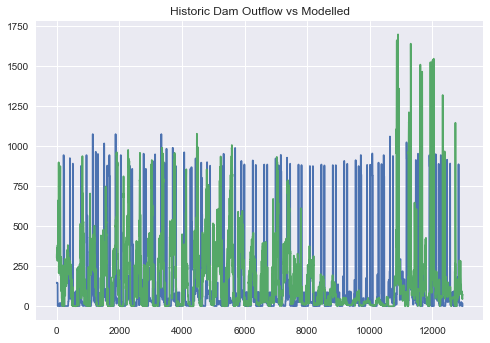

In [15]:
plt.plot(synthetic_dam_ext)
plt.plot(historic_dam_ext['Dam Release (ML)'])
plt.title("Historic Dam Outflow vs Modelled")
plt.show()

In [16]:
%%time
timesteps = len(climate_data)
for ts_idx in xrange(timesteps):
    for outlet, node in system_outlets.items():
        node.run(ts_idx, climate_data, ext_data)

Wall time: 4.03 s


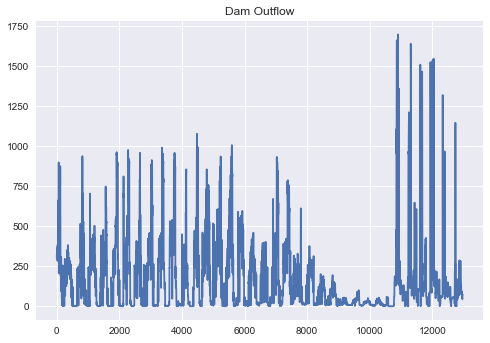

In [17]:
dam_node = network[406000]
plt.plot(dam_node._outflow)
plt.title("Dam Outflow")
plt.show()

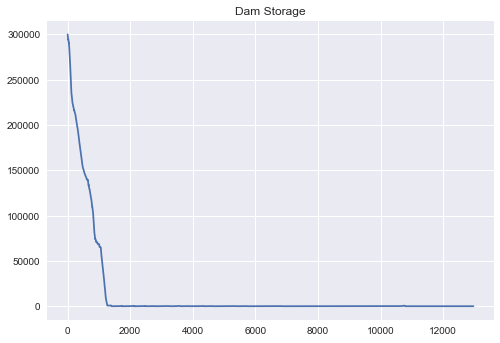

In [18]:
plt.plot(dam_node._storage)
plt.title("Dam Storage")
plt.show()

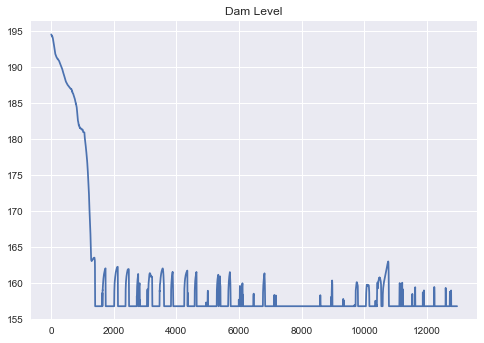

In [19]:
plt.plot(dam_node._level)
plt.title("Dam Level")
plt.show()

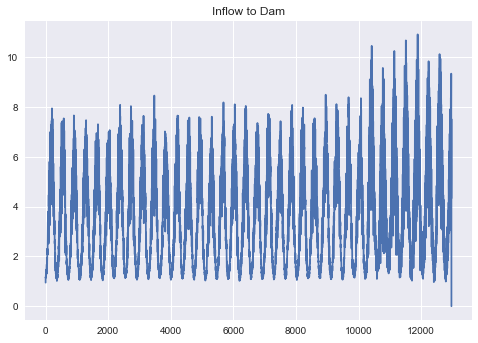

In [20]:
inflows = dam_node._inflow
plt.plot(inflows)
plt.title("Inflow to Dam")
plt.show()

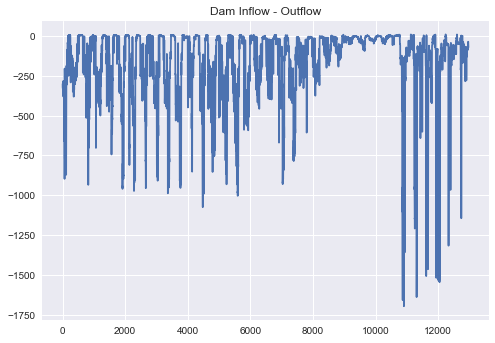

In [21]:
inflows = dam_node._inflow
plt.plot(np.array(inflows) - np.array(dam_node._outflow))
plt.title("Dam Inflow - Outflow")
plt.show()

node type ruleset

Node types:

* 1 = Top node - a node with parent node(s)
* 2 = Dam
* 3 = Member node - a node with parent node(s)
* 4 = end node

```
if node type is not 2:
    run IHACRES
    
if node type is 3:
    run routing
    update state
    
if node type is 2:
    run dam
    update state

if node type is 4:
    run routing

if node_type is not 2 and formula type is > 0:
    run level  # only the node below the dam and dam itself has a formula type > 0
```

The above workflow can be simplified using node type information

```
if node_type is not DamNode:
    run cmd  # each node is responsible for maintaining state
    run routing

if node_type is DamNode:
    run dam
    
if node_type is not DamNode and formula_type is > 0:  # i.e. node is not 2 or 3
    run level
```

In [22]:
tmp_node = network[406201]

In [23]:
tmp_node.level

AttributeError: 'StreamNode' object has no attribute 'level'

In [1]:
from pyIHACRES import ihacres_funcs
from pyIHACRES.Network import StreamNode

In [2]:
class DevStreamNode(StreamNode):
    
    def __init__(self, d, taus, vs):
        self.d = d
        self._outflow = [13.5]
        self.quick = [10.0]
        self.slow = [3.0]
        self._erain = [0.0]

        self.a, self.b = ihacres_funcs.tau_v_to_ab(taus, vs)
        
    def run(self, timestep, rain_et, extractions, prev_cmd=0.3, prev_flow=100.0):
        
        rainfall, et = rain_et
        
        e_rainfall = ihacres_funcs.calc_effective_rainfall(prev_cmd, self.d)
        
        # prev_cmd, rainfall, et, effective_rainfall
        cmd = ihacres_funcs.calc_cmd(prev_cmd, rainfall, et, e_rainfall)
        
        # No flow occurs if cmd > d
        # https://wiki.ewater.org.au/display/SD41/IHACRES-CMD+-+SRG
        if cmd > self.d:
            outflow = 0.0
            quick, slow = self.quick[timestep - 1], self.slow[timestep - 1]
        else:
            
            # calc_flows(timestep, prev_flow, e_rainfall, ab)
            quick, slow, outflow = ihacres_funcs.calc_flows(timestep, self._outflow, self._erain, (self.a, self.b))
            outflow = ihacres_funcs.calc_outflow(outflow, extractions)
        # End if

        self.append_timestep(self.quick, (timestep, quick))
        self.append_timestep(self.slow, (timestep, slow))
        self.append_timestep(self._outflow, (timestep, outflow))
        self.append_timestep(self._erain, (timestep, e_rainfall))
        
        return outflow, cmd

In [3]:
devnode = DevStreamNode(1004, (0.3, 0.7), (0.3, 0.7))

In [4]:
devnode.a

[0.27532502978902818, -0.008549309479686051]

In [5]:
outflow, cmd = devnode.run(0, (0.0, 3.0), 0.0)

('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 0.0, 0.0)


In [8]:
for i in range(30):
    # timestep, rain_et, extractions, prev_cmd=0.3, prev_flow=100.0
    outflow, cmd = devnode.run(i, (100.0, 6.0), 0.0, prev_cmd=cmd, prev_flow=devnode.outflow)
    print(cmd, outflow)

('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 1.0349576986692641, 1.0341302353008806)
(113.78896644235223, 1.0357843378709457)
('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 1.0357843378709457, 1.0349576986692641)
(20.67563081840567, 1.0308822707234166)
('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 1.0308822707234166, 1.0357843378709457)
(0.0, 1.0156114632479829)
('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 1.0156114632479829, 1.0308822707234166)
(0.0, 0.99749974771585459)
('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 0.99749974771585459, 1.0156114632479829)
(0.0, 0.98498360308434407)
('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 0.98498360308434407, 0.99749974771585459)
(0.0, 0.9758324983670793)
('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 0.9758324983670793, 0.98498360308434407)
(0.0, 0.96761355573179986)
('    ', 0.27532502978902818, -0.008549309479686051)
('    ', 0.9676

In [8]:
devnode.slow

[-0.0,
 -0.0062666882090141145,
 -0.0062666882090141145,
 -0.008665338583542714,
 -0.0093467639334342233,
 -0.0095348665147461046,
 -0.0096018051660032681,
 -0.0096395810321778727,
 -0.009670342650972082,
 -0.0096994015437151648,
 -0.0097280307712387763,
 -0.0097565354499607737,
 -0.0097849887230023972,
 -0.0098134081406657976,
 -0.009841797930349434,
 -0.0098701591265825221,
 -0.0098984919986985099,
 -0.009926796632629558,
 -0.0099550730703342194,
 -0.009983321343211447,
 -0.010011541480108316,
 -0.010039733509239104,
 -0.01006789745864522,
 -0.010096033356305451,
 -0.01012414123016241,
 -0.010152221108128872,
 -0.010180273018089344,
 -0.010208296987900442,
 -0.010236293045391009,
 -0.010264261218362164]